<a href="https://colab.research.google.com/github/idanwekhai/orbital/blob/master/OrbitalView_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/12y-UBAEBHOVvJ7HEArVbHuHXLAELhhLK"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/idanwekhai/orbital/blob/master/OrbitalView_Challenge.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

#Imports 

In [0]:
import pandas as pd
import numpy as np
import csv
import re
import os
import io
import shutil
import urllib.request
import tarfile
import cv2 
from PIL import Image
from collections import namedtuple, OrderedDict
from google.colab import files

# Install Required Stuff

In [2]:
!apt-get install -qq protobuf-compiler 
!pip install tensorflow-gpu==1.15.0
import tensorflow.compat.v1 as tf

     |████████████████████████████████| 411.5MB 26kB/s 
     |████████████████████████████████| 512kB 47.6MB/s 
     |████████████████████████████████| 3.8MB 49.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4c15c7897f2d25d8fb6d164d6b17d104f6c2fc90b723d16a28f8353450530329
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2

In [3]:
#import tensorflow as tf
print(tf.__version__)

1.15.0


#I hosted the data for this challenge on my github

In [4]:
%mkdir orbital
%cd orbital
!wget https://raw.githubusercontent.com/idanwekhai/orbital/master/data.zip
!unzip data.zip

/content/orbital
--2020-04-24 14:09:09--  https://raw.githubusercontent.com/idanwekhai/orbital/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2671683 (2.5M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.55M  --.-KB/s    in 0.06s   

2020-04-24 14:09:09 (45.0 MB/s) - ‘data.zip’ saved [2671683/2671683]

Archive:  data.zip
   creating: data/
   creating: data/annotations/
  inflating: data/annotations/image1.xml  
  inflating: data/annotations/image2.xml  
  inflating: data/annotations/image3.xml  
  inflating: data/annotations/image4.xml  
  inflating: data/annotations/image5.xml  
  inflating: data/conv.py            
   creating: data/images/
  inflating: data/images/image1.png  
  inflating: data/ima

#Download TF models and prepate the TF object detection API

In [5]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 34504 (delta 9), reused 0 (delta 0), pack-reused 34486
Receiving objects: 100% (34504/34504), 512.51 MiB | 34.58 MiB/s, done.
Resolving deltas: 100% (22214/22214), done.
Checking out files: 100% (2501/2501), done.


In [6]:
%cd models/research
#compiling the proto buffers => code from https://developers.google.com/protocol-buffers/
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/orbital/models/research/:/content/orbital/models/research/slim/'

/content/orbital/models/research


In [7]:
#%cd orbital/models/research/
!python object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

# Code to craete TF records

### Adapted form https://gist.github.com/AlaaSenjab/3db76059985e5dc850b98f2cb7c53716#file-to_tfrecord-py

In [8]:
from object_detection.utils import dataset_util

%cd /content/orbital/models/

#change this to the base directory where your data/ is 
data_base_url = '/content/orbital/data/'

#location of images
image_dir = data_base_url + 'images/'

def class_text_to_int(row_label):
    if row_label == 'following':
        return 1
    else:
        None

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
    filename = group.filename.encode('utf8')
    image_format = b'png'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        }))
    return tf_example
#creates tfrecord for both csv's
for csv in ['train_labels', 'test_labels']:
    writer = tf.io.TFRecordWriter(data_base_url + csv + '.record')
    path = os.path.join(image_dir)
    examples = pd.read_csv(data_base_url + csv + '.csv')
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    
    writer.close()
    output_path = os.path.join(os.getcwd(), data_base_url + csv + '.record')
    print('Successfully created the TFRecords: {}'.format(data_base_url +csv + '.record'))

/content/orbital/models
Successfully created the TFRecords: /content/orbital/data/train_labels.record
Successfully created the TFRecords: /content/orbital/data/test_labels.record


# Set Conig for pretrained models

In [0]:
#pretrained model
MODEL_CONFIG = {
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
    },
}

# Select a model.
selected_model = 'faster_rcnn_inception_v2'

In [10]:
%cd research/

#the distination folder where the model will be saved
DEST_DIR = '/content/orbital/models/research/pretrained_model'

# Name of the object detection model to use.
MODEL = MODEL_CONFIG[selected_model]['model_name']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#checks if the model has already been downloaded, download it otherwise
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/orbital/models/research


In [0]:
%mkdir training

In [12]:
CONFIG_BASE = "/content/orbital/models/research/object_detection/samples/configs/"
pipeline_file = 'faster_rcnn_inception_v2_coco.config'
#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)
model_pipline

'/content/orbital/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config'

In [0]:
#check the sample config file that is provided by the tf model
#!cat /content/orbital/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config

In [14]:
#editing the configuration file to add the path for the TFRecords files, pbtxt,batch_size,num_steps,num_classes.
# any image augmentation, hyperparemeter tunning (drop out, batch normalization... etc) would be editted here

%%writefile {model_pipline}
model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 900000
            learning_rate: .00002
          }
          schedule {
            step: 1200000
            learning_rate: .000002
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "/content/orbital/models/research/pretrained_model/model.ckpt"
  from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the COCO dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/orbital/data/train_labels.record"
  }
  label_map_path: "/content/orbital/data/label_map.pbtxt"
}

eval_config: {
  num_examples: 8
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
  num_visualizations: 1
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/orbital/data/test_labels.record"
  }
  label_map_path: "/content/orbital/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting /content/orbital/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config


In [0]:
# where the model will be saved at each checkpoint while training 
model_dir = 'training/'

# Optionally: remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

#Install and Activate TensorBoard

In [16]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-04-24 14:10:40--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.228.134.34, 52.7.241.210, 34.192.215.160, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.228.134.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  17.9MB/s    in 0.7s    

2020-04-24 14:10:42 (17.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
#the logs that are created while training 
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [18]:
#The link to tensorboard.
#works after the training starts.

### note: if you didnt get a link as output, rerun this cell and the one above
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://616ab24a.ngrok.io


# Train Model

In [19]:
!python3 /content/orbital/models/research/object_detection/model_main.py \
    --pipeline_config_path={model_pipline}\
    --model_dir={model_dir} \
    --alsologtostderr \

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0424 14:10:57.831766 139862326163328 module_wrapper.py:139] From /content/orbital/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0424 14:10:57.834386 139862326163328 module_wrapper.py:139] From /content/orbital/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0424 14:10:57.834528 139862326163328 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0424 14:10:57.834650 139862326163328 module_wrapper.py:139] From /cont

# Export trained model

In [22]:
#the location where the exported model will be saved in.
output_directory = '/content/orbital/models/research/fine_tuned_model'

# goes through the model is the training/ dir and gets the last one.
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
!python /content/orbital/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-5744
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0424 14:22:31.462200 140170790557568 module_wrapper.py:139] From /content/orbital/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0424 14:22:31.468212 140170790557568 module_wrapper.py:139] From /content/orbital/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0424 14:22:31.468509 140170790557568 module_wrapper.py:139] From /content/orbital/models/research/object_detection/exporter.py:121: The name tf.placeholder is depre

#Download Model Graph

In [0]:
#downloads the frozen model that is needed for inference
files.download(output_directory + '/frozen_inference_graph.pb')

In [0]:
#downlaod the label map
files.download(data_base_url + '/label_map.pbtxt')

# Make Inference

[100.]


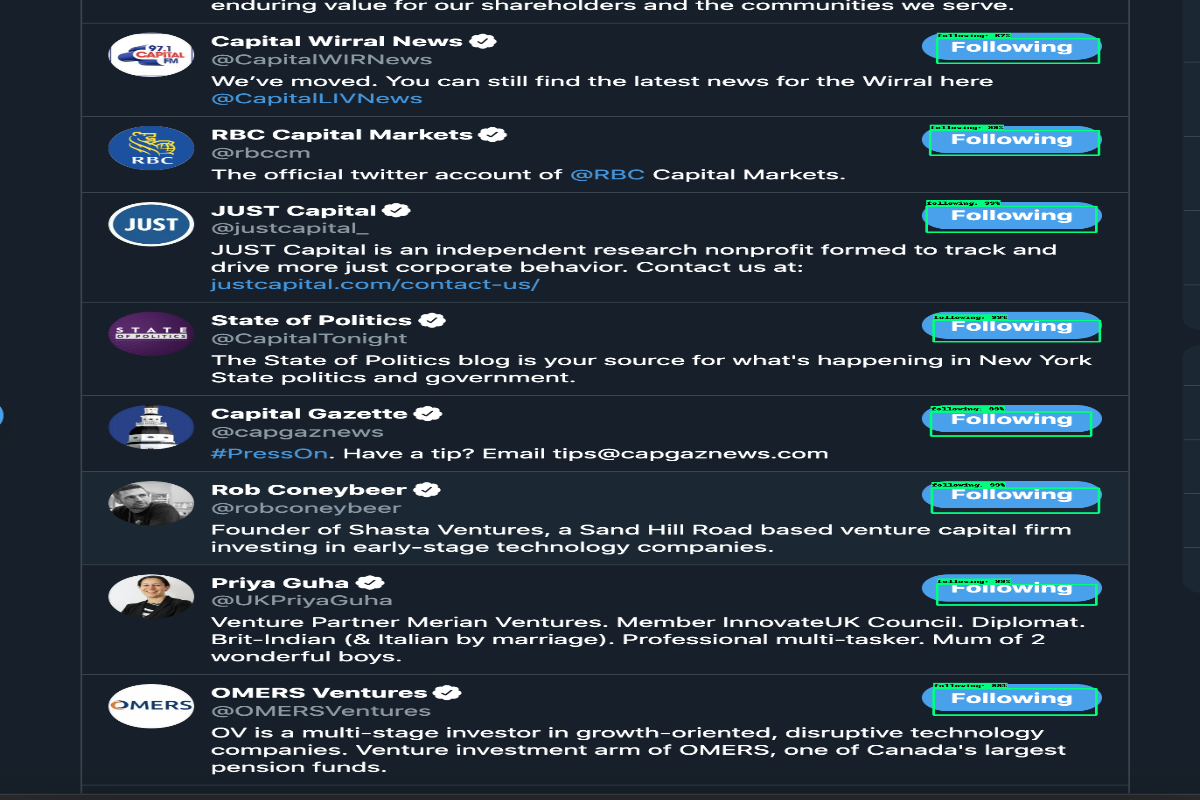

In [25]:
import numpy as np
import os
#import tensorflow as tf
import cv2
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from google.colab.patches import cv2_imshow

# path to the frozen graph:
PATH_TO_FROZEN_GRAPH = output_directory+ '/frozen_inference_graph.pb'

# path to the label map
PATH_TO_LABEL_MAP =  data_base_url + 'label_map.pbtxt'

# number of classes 
NUM_CLASSES = 1

test_image = cv2.imread('/content/orbital/data/images/image5.png')

#reads the frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABEL_MAP)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
          
        image_np = test_image
        
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Extract image tensor
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Extract detection boxes
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Extract detection scores
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        # Extract detection classes
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        # Extract number of detections
        num_detections = detection_graph.get_tensor_by_name(
            'num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        # Visualization of the results of a detection.
     
        print(num_detections)
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=3,
            #min_score_thresh=0.5
            )
    
        cv2_imshow(cv2.resize(image_np, (1200, 800)))


# Get Coordinates [ymin, xmin, ymax, xmax]

In [26]:
# This is the way I'm getting my coordinates
boxes = np.squeeze(boxes) 
# get all boxes from an array
max_boxes_to_draw = boxes.shape[0]
# get scores to get a threshold
scores = np.squeeze(scores) 
min_score_thresh=.5

# iterate over all objects found
for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    # 
    if scores is None or scores[i] > min_score_thresh:
        # boxes[i] is the box which will be drawn
        print ("Coordinates", boxes[i])

Coordinates [0.16327158 0.77489406 0.19370714 0.9157933 ]
Coordinates [0.5147684  0.77557343 0.544943   0.9090946 ]
Coordinates [0.40052572 0.77839726 0.4271618  0.91669464]
Coordinates [0.8611863  0.77781576 0.89360183 0.913644  ]
Coordinates [0.73069036 0.78126705 0.75630754 0.9137446 ]
Coordinates [0.25770912 0.7725441  0.2901563  0.9137946 ]
Coordinates [0.6101855  0.7764553  0.64140785 0.9161292 ]
Coordinates [0.04827287 0.78069854 0.07893687 0.9154601 ]
